In [1]:
from citrination_client import CitrinationClient
from os import environ
from citrination_client import PifQuery
client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')

In [2]:
from dfttopif import directory_to_pif
pif = directory_to_pif("/home/maxhutch/science/alloy.pbe/B/B.hR12")

In [3]:
from pypif.util.read_view import ReadView
rv = ReadView(pif)
print(rv.keys())
print(rv.chemical_formula)

dict_keys(['Forces', 'Relaxed', 'Converged', 'Density Functional Theory', 'Total Energy', 'k-Points per Reciprocal Atom', 'XC Functional', 'Psuedopotentials', 'Cutoff Energy', 'positions', 'VASP', 'Positions', 'Pressure'])
B12


In [4]:
import os
import os.path
Cu_pif = directory_to_pif("/home/maxhutch/science/alloy.pbe/Cu/Cu.cF4")
Al_pif = directory_to_pif("/home/maxhutch/science/alloy.pbe/Al/Al.cF4")
AlCu_pifs = [directory_to_pif(os.path.join("/home/maxhutch/science/alloy.pbe/AlCu/", x)) for x in os.listdir("/home/maxhutch/science/alloy.pbe/AlCu/")]

In [5]:
def enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu):
    return (energy - n_Al * energy_Al - n_Cu * energy_Cu) / (n_Al + n_Cu)

In [6]:
import re
def get_stoich(AlCu_formula):
    m = re.match(r"Al([0-9]*)Cu([0-9]*)", AlCu_formula)
    if m is not None:
        n_Al = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Cu = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    m = re.match(r"Cu([0-9]*)Al([0-9]*)", AlCu_formula)
    if m is not None:
        n_Cu = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Al = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    return (0, 0)

In [7]:
energy_Al = ReadView(Al_pif)["Total Energy"].scalars[0].value / 4
energy_Cu = ReadView(Cu_pif)["Total Energy"].scalars[0].value

points = [(0.0, 0.0), (1.0, 0.0)]
for pif in AlCu_pifs:
    rv = ReadView(pif)
    energy = rv["Total Energy"].scalars[0].value
    n_Al, n_Cu = get_stoich(rv.chemical_formula)
    points.append((
            n_Cu / (n_Cu + n_Al),
            enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu)
        ))

# Introduction to Queries

Queries allow you to search and download PIFs from Citrination.  By basing scripts on queries intead of local files, you can:
 1. Share data with your group without running internal infrastructure or worrying about portability
 1. Expand your queries to include data uploaded by other groups in your field
 1. Publish post-processing scripts backed by Citrination data to improve reproducibility

## Query interfaces

There are multiple interfaces to a unified backend based on elastic search:
 1. The website
 1. The python and java citrination clients 
 1. A REST API 
 
This tutorial will focus on the python citrination client

## `PifQuery`

Each search and download request is stored in a query object: the `PifQuery`.

In [8]:
from citrination_client import PifQuery
dataset_id = 150689
query_dataset = PifQuery(include_datasets=[dataset_id])
query_result = client.search(query_dataset)
print("Found {} PIFs in dataset {}".format(query_result.total_num_hits, dataset_id))

Found 3 PIFs in dataset 150689


The result contains the matching PIFs:

In [9]:
from pypif.pif import dumps
pifs = [x.system for x in query_result.hits]
print(dumps(pifs[0], indent=2)[:300])

{
  "category": "system.chemical",
  "uid": "5DBE7209175D1550EE7AF4882CC23624",
  "chemicalFormula": "B12",
  "properties": [
    {
      "method": {
        "software": [
          {
            "name": "VASP",
            "version": "5.2.12"
          }
        ],
        "name": "Density Function


The query can include multiple datasets to bring in data from collaborators:

In [10]:
my_dataset_id = 758; another_dataset_id = 150689
query_dataset = PifQuery(include_datasets=[my_dataset_id, another_dataset_id])
query_result = client.search(query_dataset)
print("Found {} PIFs in datasets {} and {}".format(
        query_result.total_num_hits, my_dataset_id, another_dataset_id
    ))

Found 3 PIFs in datasets 758 and 150689


# Advanced Queries

Writing analysis and post-processing on top of PIFs lets us:
 1. Pull in data from collaborators and published sources
 1. Share our methodology with other researchers with data in PIFs

Let's actually do that!

## Real example: phase stability diagram

There are surely more Al-Cu binaries on Citrination.  We will:
 1. Find relevant data via the web interface
 2. Filter the data programatically with the query
 3. Extract the data using query extractions
 4. Add the data to our plot from before

## Search for relevant data

The exploratory search is usually best done on the website.  Tips and tricks:
 * "AlxCuy" searches for any Al-Cu binary
 * "energy" searches for properties with "energy" in their name

## Adding filters to the query

Now that we are querying beyond just our data, we need to filter down to records that contain Al-Cu energies.

### Filter by chemical formula

In [11]:
from citrination_client import PifQuery, SystemQuery, ChemicalFieldOperation, ChemicalFilter
query = PifQuery(system=SystemQuery(chemical_formula=ChemicalFieldOperation(filter=ChemicalFilter(equal='AlxCuy'))))
query_result = client.search(query)
print("Found {} PIFs".format(query_result.total_num_hits))

Found 81 PIFs


### Filter by property

In [12]:
from citrination_client import PropertyQuery, FieldOperation, Filter
query = PifQuery(system=SystemQuery(
        chemical_formula=ChemicalFieldOperation(filter=ChemicalFilter(equal='AlxCuy')),
        properties=PropertyQuery(name=FieldOperation(filter=Filter(equal="Formation energy")))
    ))
query_result = client.search(query)
print("Found {} PIFs".format(query_result.total_num_hits))

Found 8 PIFs


In [13]:
from pypif.pif import dumps
print(dumps(query_result.hits[1].system, indent=2))

{
  "category": "system.chemical",
  "uid": "45EE4836D26FB942587B4CD8CE4A9C20",
  "chemicalFormula": "Cu5Al",
  "properties": [
    {
      "scalars": [
        {
          "value": "Hf[5]Sc*-h51"
        }
      ],
      "name": "Structure designation"
    },
    {
      "units": "eV/atom",
      "scalars": [
        {
          "value": "-0.1288"
        }
      ],
      "name": "Formation energy",
      "dataType": "COMPUTATIONAL"
    }
  ],
  "references": [
    {
      "doi": "10.1016/j.commatsci.2012.02.002",
      "citation": "10.1016/j.commatsci.2012.02.002"
    },
    {
      "doi": "10.1016/j.commatsci.2012.02.005",
      "citation": "10.1016/j.commatsci.2012.02.005"
    }
  ]
}


## Extract data from results using the query language

Multiple sources typically use multiple internal formats.  The query language is smart about crawling the PIFs for properties with the right names, while `pypif` is not.  Fortunately, you can use the query language to do data extraction as well!

### Using `extract_as`

In [14]:
query = PifQuery(system=SystemQuery(
        chemical_formula=ChemicalFieldOperation(
            filter=ChemicalFilter(equal='AlxCuy'),
            extract_as="formula"
        ),
        properties=PropertyQuery(
            name=FieldOperation(
                filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]
            ),
            value=FieldOperation(
                extract_as="formation_enthalpy"
            )
        )
    ))
query_result = client.search(query)
print([x.extracted for x in query_result.hits[0:2]])

[{'formation_enthalpy': '-0.1978', 'formula': 'CuAl'}, {'formation_enthalpy': '-0.1288', 'formula': 'Cu5Al'}]


A few notes:
 * `extract_as` extracts the field it is on (why we need value)
 * `extracted` is a dictionary from String keys to values; no units or uncertainty

## Real example: phase stability diagram

Let's add these points to our Al-Cu phase diagram.

In [15]:
new_points = []
for hit in query_result.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((
            n_Cu / (n_Cu + n_Al),
            hit.extracted["formation_enthalpy"]
        ))

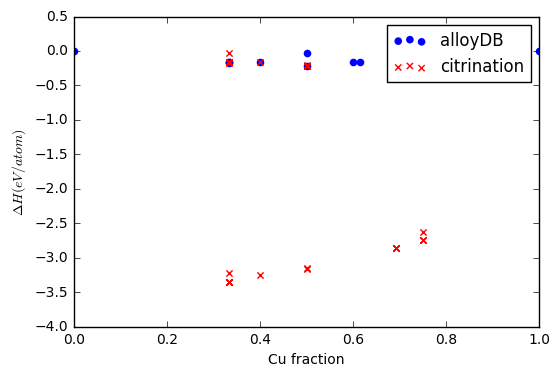

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*points), color='blue', marker='o', label='alloyDB')
plt.scatter(*zip(*new_points), color='red', marker='x', label='citrination')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")

### Filter by value

A few of the values in are mislabeled: they are called "Enthalpy of Formation" but are actually total energies (per atom).  We can filter them out by recognizing that all the Al-Cu binaries have enthalpy of formation above $-1.0 eV / $atom.

In [17]:
query = PifQuery(system=SystemQuery(
        chemical_formula=ChemicalFieldOperation(
            filter=ChemicalFilter(equal='AlxCuy'),
            extract_as="formula"
        ),
        properties=PropertyQuery(
            name=FieldOperation(
                filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]
            ),
            value=FieldOperation(
                extract_as="formation_enthalpy",
                filter=[Filter(min=-1.0)]
            )
        )
    ))
query_result = client.search(query)

In [18]:
new_points = []
for hit in query_result.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((
            n_Cu / (n_Cu + n_Al),
            hit.extracted["formation_enthalpy"]
        ))

This looks much better:

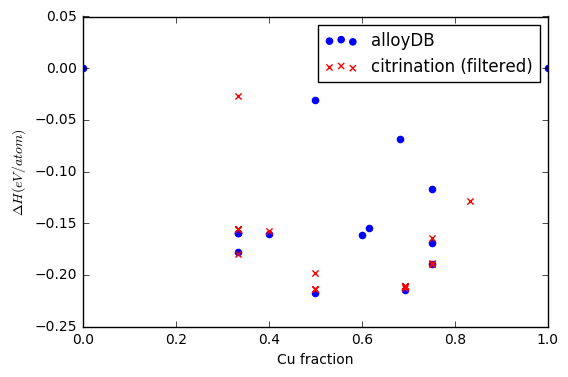

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*points), color='blue', marker='o', label='alloyDB')
plt.scatter(*zip(*new_points), color='red', marker='x', label='citrination (filtered)')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")